# Parameters Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("../loan-clean.csv")

In [3]:
df_credit_1 = df[df["Credit_History"] == 1].sample(90)
df_credit_0 = df[df["Credit_History"] == 0]

df = pd.concat([df_credit_1, df_credit_0], ignore_index=True)
df.reset_index(inplace=True)
df.shape

(179, 15)

In [4]:
df.replace({"Dependents": '3+'}, {"Dependents": 3}, inplace=True)
df = df.astype({"Dependents": "int16"})

In [5]:
df["Loan_Status"] = np.where(df["Loan_Status"] == 'Y', 1, 0)

## One-Hot Encoder

In [6]:
categorical_features = ["Gender", "Married", "Education",
                        "Self_Employed", "Property_Area"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
matrix = encoder.fit_transform(df[categorical_features])
encoder_feature_names = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(data=matrix, columns=encoder_feature_names)
df = pd.merge(df, df_encoded, left_index=True, right_index=True)
df.drop(columns=categorical_features, inplace=True)

df.head()

,index,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Income,...,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,LP002181,0,6216,0.0,133.0,360.0,1.0,0,6216.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1,LP001518,1,1538,1425.0,30.0,360.0,1.0,1,2963.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,LP002250,0,5488,0.0,125.0,360.0,1.0,1,5488.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,LP001392,1,7451,0.0,148.0,360.0,1.0,1,7451.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,LP002129,0,2499,2458.0,160.0,360.0,1.0,1,4957.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Scaling

In [7]:
df_list = []
scaler_names = ["MinMax", "Standard", "Robust"]

In [8]:
features_to_scale = ["Dependents", "ApplicantIncome", "CoapplicantIncome", "Income",
                    "LoanAmount", "Loan_Amount_Term"]

scaler = MinMaxScaler(clip=True)
df_temp = df.copy()
df_temp[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df_list.append(df_temp)

scaler = StandardScaler()
df_temp = df.copy()
df_temp[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df_list.append(df_temp)

scaler = RobustScaler()
df_temp = df.copy()
df_temp[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df_list.append(df_temp)

len(df_list)

3

In [9]:
df_list[1].head()

,index,Loan_ID,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Income,...,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,LP002181,-0.811101,0.123462,-0.790015,-0.172387,0.274626,1.0,0,-0.090602,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1,LP001518,0.150403,-0.534422,-0.048706,-1.537052,0.274626,1.0,1,-0.550596,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2,LP002250,-0.811101,0.021081,-0.790015,-0.278381,0.274626,1.0,1,-0.193546,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,3,LP001392,0.150403,0.297145,-0.790015,0.026350,0.274626,1.0,1,0.084034,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,LP002129,-0.811101,-0.399273,0.488679,0.185340,0.274626,1.0,1,-0.268632,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Spliting & Modeling 

In [10]:
loss_curves = {}
val_curves = {}
test_scores = {}
train_scores = {}
f1_scores = {}

solvers = ["adam", "sgd"]
hidden_layers = [(100, 80, 50,), (200, 200, 200,), (30, 30,), (50, 25,), (1000,), (80, 100, 80,)]

for index, df in enumerate(df_list):
    df.drop(columns=["Loan_ID"], inplace=True)
    X = df.drop(columns=["Loan_Status"]) # features
    y = df[["Loan_Status"]] # target label
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.20,
                                                        random_state=42)

    for solver in solvers:
        for hl in hidden_layers:
            # Fitting model based on the train data
            model = MLPClassifier(
                        random_state=42,
                        max_iter=1000,
                        solver=solver,
                        hidden_layer_sizes=hl,
                        n_iter_no_change=50,
                        early_stopping=True, # it uses 10% of training for validation
                        verbose=False)
            model.fit(X_train, y_train.astype("int"))
            loss_curves[f"{scaler_names[index]}-{solver}-{hl}"] = model.loss_curve_
            val_curves[f"{scaler_names[index]}-{solver}-{hl}"] = model.validation_scores_
            test_scores[f"{scaler_names[index]}-{solver}-{hl}"] = model.score(X_test, y_test)
            train_scores[f"{scaler_names[index]}-{solver}-{hl}"] = model.score(X_train, y_train)
            
            predictions = model.predict(X_test)
            f1_scores[f"{scaler_names[index]}-{solver}-{hl}"] = f1_score(y_test, predictions)

C:\ProgramData\Miniconda3\envs\ai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Miniconda3\envs\ai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Miniconda3\envs\ai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Miniconda3\envs\ai\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataC

## Visualization

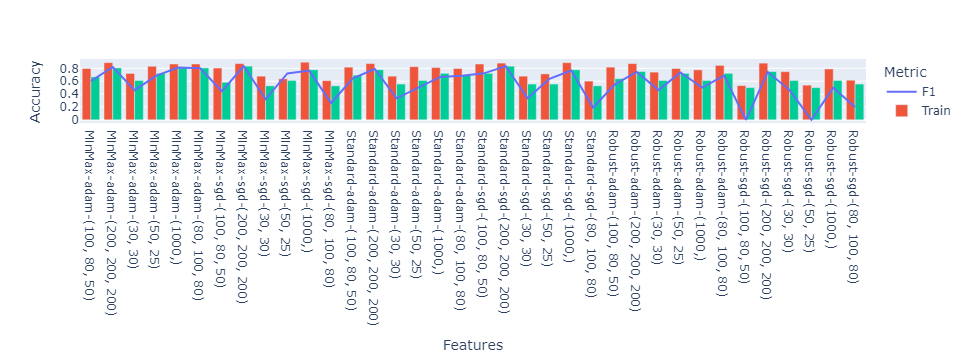

In [20]:
import plotly.express as px

fig = px.line(x=list(f1_scores.keys()), y=list(f1_scores.values()), color=px.Constant("F1"),
             labels=dict(x="Features", y="Accuracy", color="Metric"))
fig.add_bar(x=list(train_scores.keys()), y=list(train_scores.values()), name="Train")
fig.add_bar(x=list(test_scores.keys()), y=list(test_scores.values()), name="Test")
fig.update_layout({"height": 500})
fig.show()

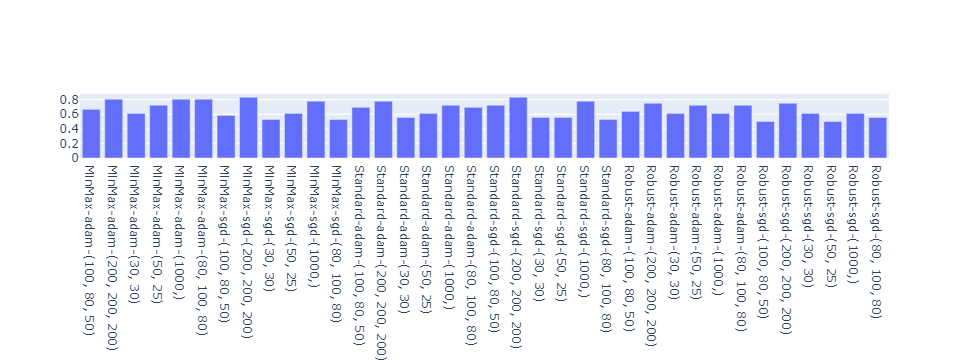

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(x=list(test_scores.keys()), y=list(test_scores.values())))
fig.show()

C:\Users\Kaveh\AppData\Roaming\Python\Python310\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




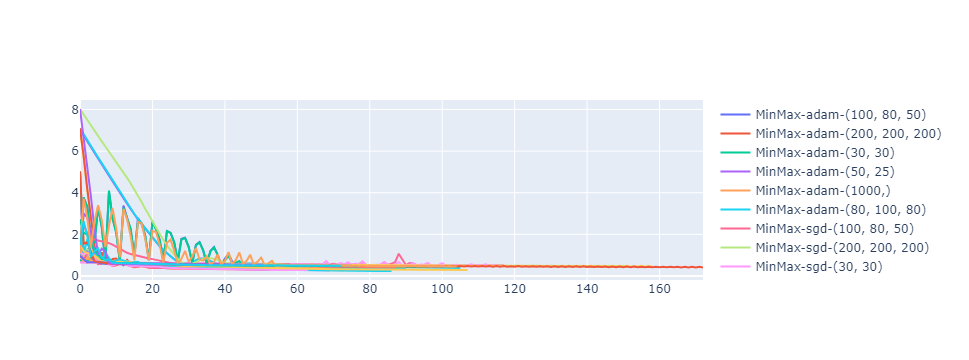

In [13]:
fig = go.Figure()
for key in loss_curves.keys():
    fig.add_trace(go.Line(x=list(range(len(loss_curves[key]))),
                           y=loss_curves[key],
                           name=key))
fig.update_layout({"height": 700})
fig.show()

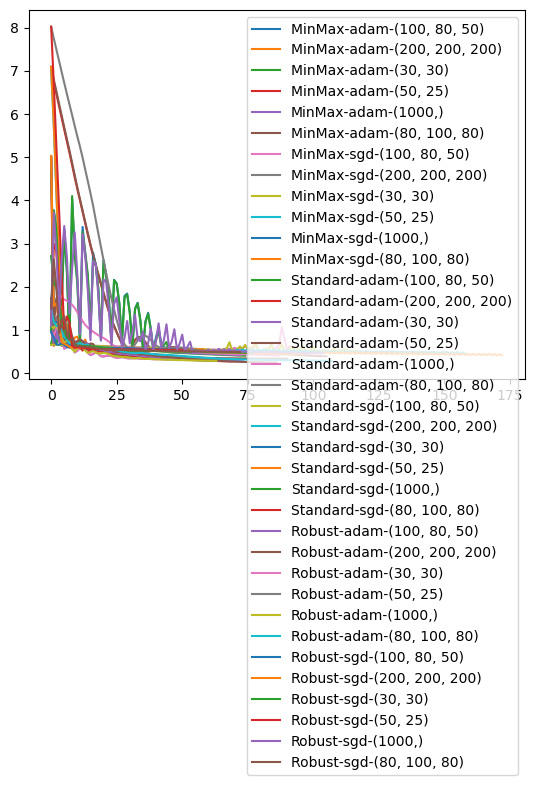

In [14]:
for key in loss_curves.keys():
    plt.plot(loss_curves[key],
             label=key)
plt.legend()
plt.show()

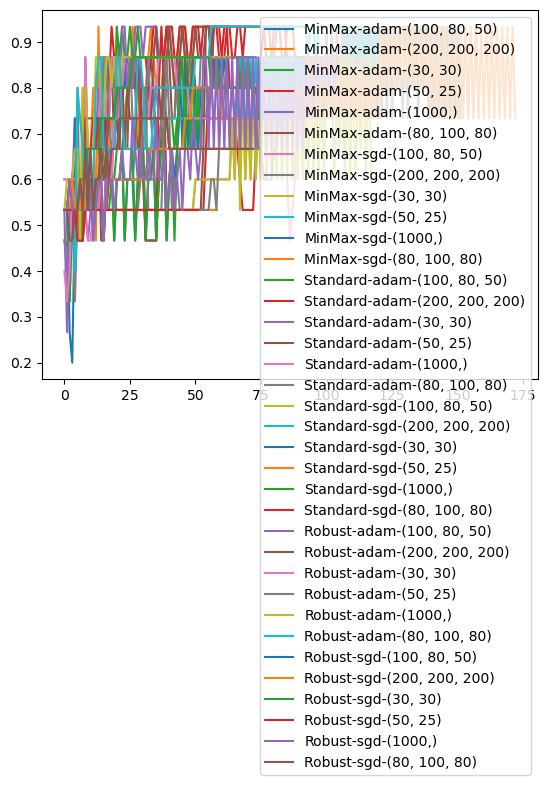

In [15]:
for key in val_curves.keys():
    plt.plot(val_curves[key],
             label=key)
plt.legend()
plt.show()
